In [157]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from scipy.io import loadmat
import numpy as np, os
import matplotlib.pyplot as plt

keys cats: __header__ __version__ __globals__ cat_wave


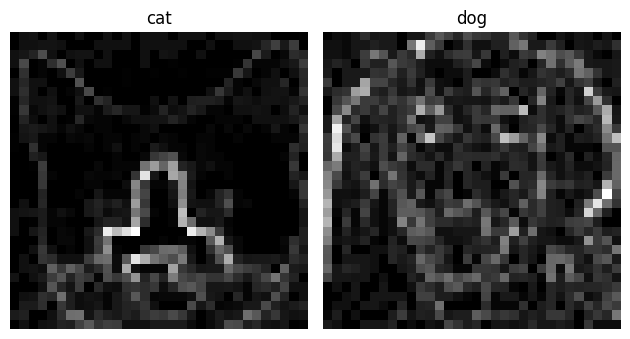

In [158]:
cats2 = loadmat(os.path.join('data_processing','media','catData_w.mat'))
dogs2 = loadmat(os.path.join('data_processing','media','dogData_w.mat'))
print('keys cats:',*cats2.keys())
cats_data2 = cats2['cat_wave']
dogs_data2 = dogs2['dog_wave']

fig, ax = plt.subplots(1,2,tight_layout=True)
cat_w_img = cats_data2[:,0].reshape(32,32).T
ax[0].imshow(cat_w_img, 'gray')
dog_w_img = dogs_data2[:,0].reshape(32,32).T
ax[1].imshow(dog_w_img, 'gray')
ax[0].set_title('cat')
ax[0].axis('off')
ax[1].set_title('dog')
ax[1].axis('off');

In [159]:

cats_dogs2 = np.hstack((cats_data2,dogs_data2)); print(cats_dogs2.shape)
U,S,V = np.linalg.svd(cats_dogs2-np.mean(cats_dogs2, axis= 0),full_matrices=False)
modeA = 2; modeB = 4
coordsAB = V[[modeA,modeB]] # (2,N) -  two rows

(1024, 160)


(80, 2)
0.7875


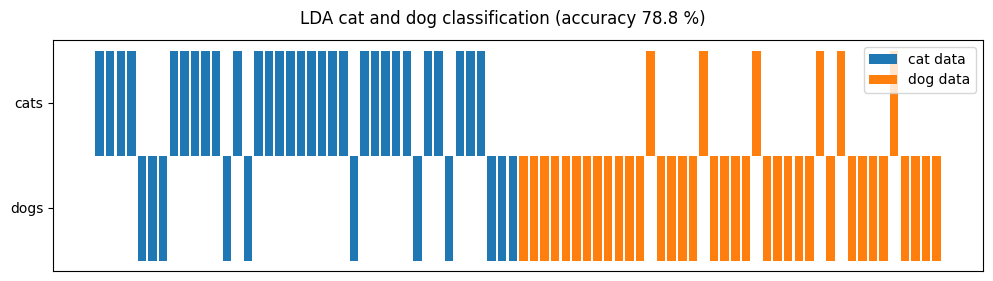

In [160]:

num_train = 40; num_test = 80 - num_train
catsAB = coordsAB[:,:80].T  # N,2
dogsAB = coordsAB[:,80:].T
print(catsAB.shape)
#np.random.seed(69)

def train(catsAB,dogsAB, lda = LinearDiscriminantAnalysis()):
     #lda.fit(X,y) X = (n_samples, n_features), y = (n_samples,)
    np.random.shuffle(catsAB)
    np.random.shuffle(dogsAB)
    # train model
    xtrain = np.vstack((catsAB[:num_train], dogsAB[:num_train]))
    #print('xtrain dims: ', xtrain.shape)
    ytrain = np.repeat(np.array([1,-1]),num_train)  #[1,1,1,...,-1,-1,-1]
    lda.fit(xtrain,ytrain)
    # test model
    #lda.predict(X) X = (n_samples, n_features)
    xtest = np.vstack((catsAB[num_test:], dogsAB[num_test:]))
    ytest = np.repeat(np.array([1,-1]),num_test)  #[1,1,1,...,-1,-1,-1]
    classes = lda.predict(xtest)

    correct = classes == ytest
    correct_prob = np.mean(correct)
    return correct_prob, classes, lda

correct_prob, classes,_ = train(catsAB,dogsAB)
print(correct_prob)
fig,ax = plt.subplots(1, figsize = (12,3))
ax.bar(range(num_test),classes[:num_test], label='cat data')
ax.bar(range(num_test, 2*num_test),classes[num_test:], label='dog data')
plt.suptitle(f'LDA cat and dog classification (accuracy {correct_prob*100:0.1f} %)')
plt.yticks([-0.5, 0.5], ['dogs', 'cats'])
plt.xticks([])
plt.legend()


(0.0, 1.0)

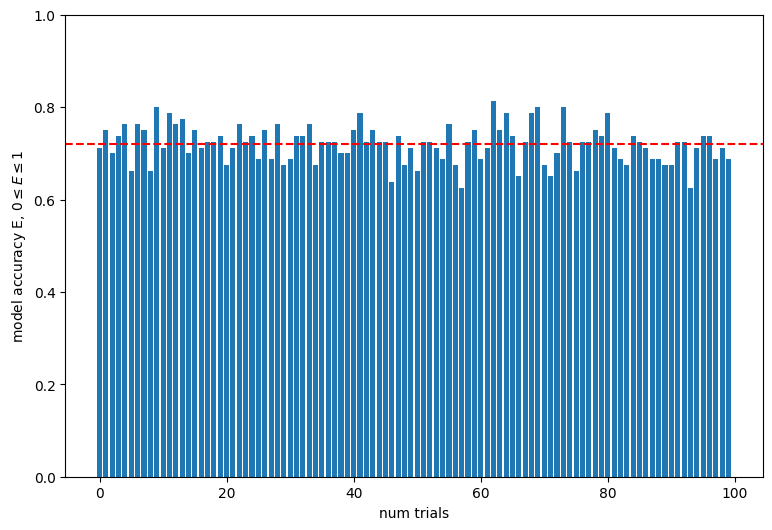

In [161]:
N = 100
E = np.zeros(N, float)
for i in range(N):
    correct_prob = train(catsAB,dogsAB)[0]
    E[i] = correct_prob

fig,ax = plt.subplots(1, figsize = (9,6))
ax.bar(range(N), E)
ax.axhline(y = np.mean(E), c='r', ls='--', label='avg accuracy')
ax.set_ylabel(r'model accuracy E, $0\leq E \leq 1$')
ax.set_xlabel(r'num trials')
ax.set_ylim(0,1)

In binary case LDA provides parameters of a line separating data in $s_1,s_2$ space.<br>
Equation of a line is:
$$c_1 s_1 + c_2 s_2 + b == 0$$
$c_1,c_2$ are held in **lda.coef_**,<br>
vertical intercept $b$ in **lda.intercept_**

For a horizontal line plot:
$$s_2(s_1) = \frac{-1}{c_2}(c_1 s_1 + b)$$

[0.32696123] [[12.14540224  2.69201073]]


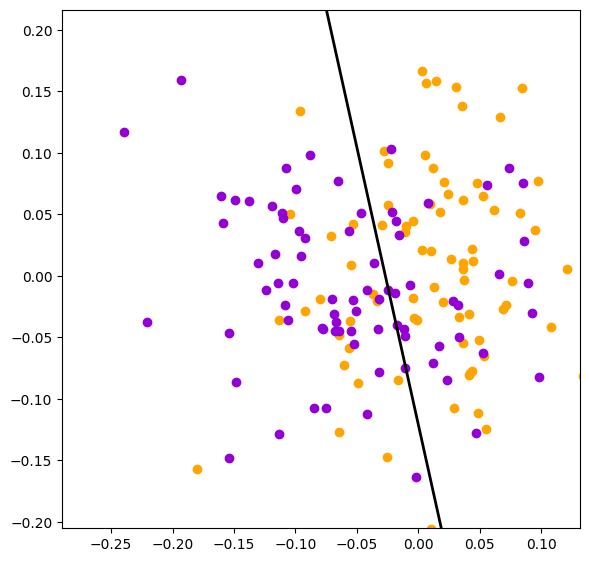

In [162]:

mn1,mn2 = np.min(coordsAB, axis = 1) + [-0.05,0.05]
mx1,mx2 = np.max(coordsAB, axis = 1) + [-0.05,0.05]
correct_prob, classes, lda = train(catsAB,dogsAB)
b = -lda.intercept_[0]
c1,c2 = -lda.coef_[0]
s1 = np.linspace(mn1,mx1,2)
print(lda.intercept_, lda.coef_)
fig, ax = plt.subplots(1,tight_layout=True, figsize = (6,6), sharex=True, sharey=True)
ax.set_xlim(mn1,mx1)
ax.set_ylim(mn2,mx2)
ax.scatter(*catsAB.T, color= 'orange')
ax.scatter(*dogsAB.T, color= 'darkviolet')
ax.plot(s1,-1/c2*(c1*s1 +b),'k',lw=2)
ax.set_aspect('equal')

## Quadratic Discriminant Analysis
Plotting QDA boundary is not as simple as in case with LDA. In QDA case we are dealing with quadratic function.

### One way is to sample prediction and extract boundary between -1 and 1

In [163]:
num = 400
x_vals = np.linspace(mn1, mx1, num)
y_vals = np.linspace(mn2, mx2, num)
X, Y = np.meshgrid(x_vals, y_vals)
Z = np.zeros(shape=(num,num), dtype=float)

xtrain = np.vstack((catsAB, dogsAB))
ytest = np.repeat(np.array([1,-1]),80)
qda = QuadraticDiscriminantAnalysis()
qda.fit(xtrain,ytest)
for i,x in enumerate(x_vals):
    for j,y in enumerate(y_vals):
        Z[i,j] = qda.predict([[x,y]])[0]   

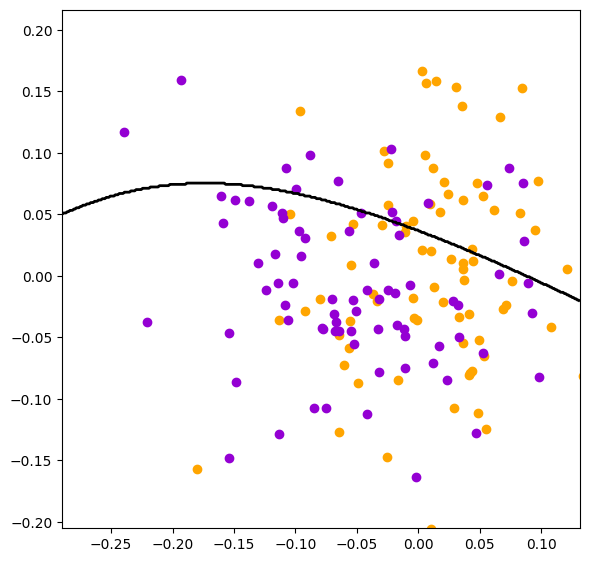

In [164]:
fig, ax = plt.subplots(1,tight_layout=True, figsize = (6,6), sharex=True, sharey=True)
ax.set_xlim(mn1,mx1)
ax.set_ylim(mn2,mx2)
ax.scatter(*catsAB.T, color= 'orange')
ax.scatter(*dogsAB.T, color= 'darkviolet')
ax.contour(X,Y,Z,0,colors='k',linewidths=2)    
ax.set_aspect('equal')

In [165]:
from sklearn.inspection import DecisionBoundaryDisplay
import matplotlib as mpl
def plot_ellipse(mean, cov, color, ax):
    v, w = np.linalg.eigh(cov)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(
        mean,
        2 * v[0] ** 0.5,
        2 * v[1] ** 0.5,
        angle=180 + angle,
        facecolor=color,
        edgecolor="black",
        linewidth=2,
    )
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.4)
    ax.add_artist(ell)

### Or draw boundary using DecisionBoundaryDisplay.from_estimator()

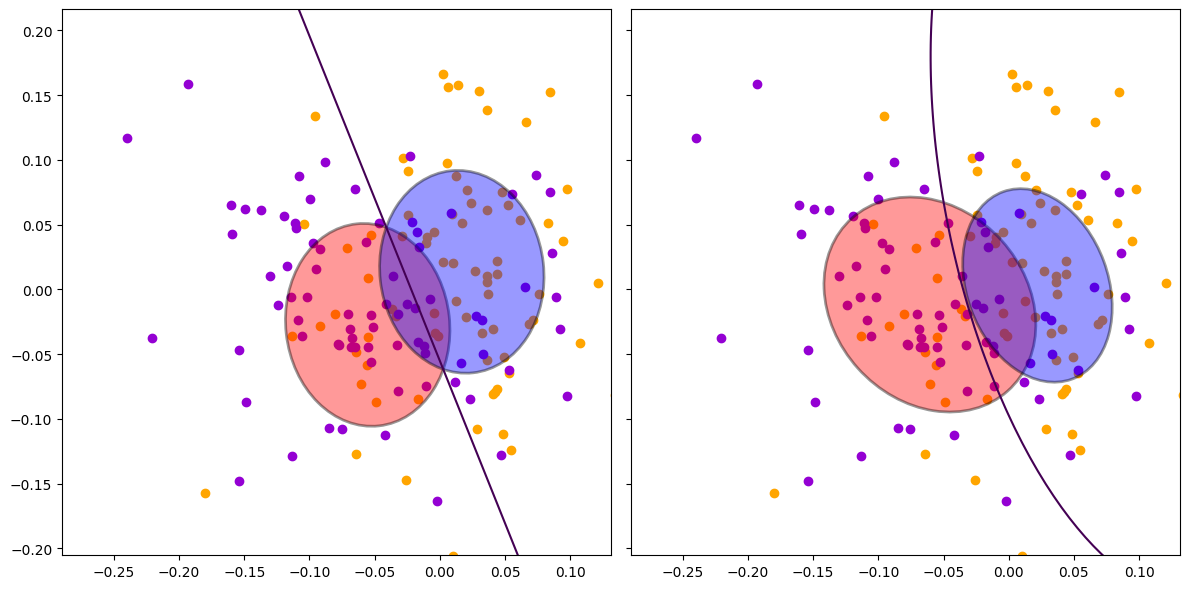

In [166]:
fig, ax = plt.subplots(1,2,tight_layout=True, figsize = (12,6), sharex=True, sharey=True)
for i, lda0 in enumerate([LinearDiscriminantAnalysis(store_covariance=True), QuadraticDiscriminantAnalysis(store_covariance=True)]):
    correct_prob, classes, estimator = train(catsAB,dogsAB, lda=lda0)
    xtrain = np.vstack((catsAB, dogsAB))
    DecisionBoundaryDisplay.from_estimator(
            estimator,
            xtrain,
            grid_resolution=400,
            response_method="auto",
            plot_method="contour",
            ax=ax[i],
            #cmap="RdBu",
            alpha=1.0,
            levels=[0],
        )

    ax[i].set_xlim(mn1,mx1)
    ax[i].set_ylim(mn2,mx2)
    ax[i].scatter(*catsAB.T, color= 'orange')
    ax[i].scatter(*dogsAB.T, color= 'darkviolet')
    
    if isinstance(estimator, LinearDiscriminantAnalysis):
        covariance = [estimator.covariance_] * 2
    else:
        covariance = estimator.covariance_

    plot_ellipse(estimator.means_[0], covariance[0],'r',ax[i])
    plot_ellipse(estimator.means_[1], covariance[1],'b',ax[i])